In [1]:
# implement sigmoid and tanh output layer

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../module/')

import keras2
from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
from util import moving_average, dlqr, discretized_system, lqr
import gym2
from rl2.agents import selfDDPGAgent
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
# GymのPendulum環境を作成
env = gym2.make("Pendulum-v2")
clip = 10.
env.max_torque, max_torque = clip, clip
env.action_space.high, env.action_space.low = max_torque, -max_torque
control_interval = 5

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [3]:
def _actor_initial_weight(actor):
    m, l, g = env.m, env.l, env.g

    A = np.array([[0, 1], [(3*g)/(2*l), 0]])
    B = np.array([[0], [3/(m*l**2)]])
    Q = np.array([[1, 0], [0, 0.1]])
    R = np.array([[0.01]])
    
    Ad, Bd = discretized_system(A, B, control_interval * dt)
    
    K = dlqr(Ad,Bd,Q,R)[0]
    K = lqr(A,B,Q,R)[0]
    
    weights = []
    for i in range(len(actor.layers)):
        if i < 2:
            continue
        else:
            w, b = actor.layers[i].get_weights()
            # w, b = np.zeros_like(w), np.zeros_like(b)
            w, b = np.random.randn(w.shape[0], w.shape[1]) / 1., np.random.randn(b.shape[0]) / 1. 
            if i == 2:
                w[0][0] = K[0]
                w[1][0] = K[1]
            elif i == 4:
                w[0][0] = 1
                if w.shape[1] != 1:
                    w[1][1] = 1
            else:
                w[0][0] = 1
            weights.append(w)
            weights.append(b)
    return weights

def actor_net(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input)
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(2, activation="self_trigger_output")(x)
    actor = Model(inputs=action_input, outputs=x)
    actor.summary()
    # actor.set_weights(_actor_initial_weight(actor))
    return actor

def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

In [4]:
def agent(a_shape, s_shape):
    actor = actor_net(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = selfDDPGAgent(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        clip_com = 0.01
    )
    return agent

In [5]:
#safe learning
l = 0.5
step = 300000
episode_step = 500 # 入力が加えられる回数を200(dt=0.05)にする
a = agent((2,), (2,))
a.compile(Adam(lr=0.001, clipnorm=1.), metrics=["mae"])
# a.load_weights('../learned_models_vol2/0.5standup-agent.h5')
# a.load_weights('../../learned_models_stab/lqr_optimal_agent.h5')
out = a.fit(env, l=l, nb_steps=step, visualize=0, verbose=0, nb_max_episode_steps=episode_step, action_repetition=control_interval)




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 2)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                48        
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 354
Trainable params: 354
Non-trainable params: 0
_________________________________________________________________



0:  tau = 0.5141271352767944, dt = 0.004991525585211596, action_repetition = 103, reward = -0.05472927146122569
1:  tau = 0.67876178026199

80:  tau = 0.3071572780609131, dt = 0.00495414964614376, action_repetition = 62, reward = -1.8449986766502415
81:  tau = 0.30715709924697876, dt = 0.004954146762048045, action_repetition = 62, reward = -1.844996948715853
82:  tau = 0.307157039642334, dt = 0.004954145800682807, action_repetition = 62, reward = -1.84499696802508
83:  tau = 0.3071570098400116, dt = 0.004954145320000187, action_repetition = 62, reward = -1.844997749490276
84:  tau = 0.30715706944465637, dt = 0.004954146281365425, action_repetition = 62, reward = -1.8449982594629424
85:  tau = 0.30715715885162354, dt = 0.004954147723413283, action_repetition = 62, reward = -1.8449980310482037
86:  tau = 0.30715715885162354, dt = 0.004954147723413283, action_repetition = 62, reward = -1.844997307822872
87:  tau = 0.3071569800376892, dt = 0.004954144839317568, action_repetition = 62, reward = -1.8449970151496202
88:  tau = 0.30715706944465637, dt = 0.004954146281365425, action_repetition = 62, reward = -1.8449976876253236
89:

173:  tau = 0.30715706944465637, dt = 0.004954146281365425, action_repetition = 62, reward = -1.8449979403929966
174:  tau = 0.30715709924697876, dt = 0.004954146762048045, action_repetition = 62, reward = -1.844997637473246
175:  tau = 0.30715709924697876, dt = 0.004954146762048045, action_repetition = 62, reward = -1.8449972225021223
176:  tau = 0.30715706944465637, dt = 0.004954146281365425, action_repetition = 62, reward = -1.8449971371539726
177:  tau = 0.3071570098400116, dt = 0.004954145320000187, action_repetition = 62, reward = -1.844997479483584
178:  tau = 0.3071569800376892, dt = 0.004954144839317568, action_repetition = 62, reward = -1.8449981854773394
179:  tau = 0.3071572780609131, dt = 0.00495414964614376, action_repetition = 62, reward = -1.8449990680634334
180:  tau = 0.30715712904930115, dt = 0.004954147242730664, action_repetition = 62, reward = -1.8449972823585556
181:  tau = 0.30715709924697876, dt = 0.004954146762048045, action_repetition = 62, reward = -1.844996

266:  tau = 0.30715706944465637, dt = 0.004954146281365425, action_repetition = 62, reward = -1.8449987909913268
267:  tau = 0.3071572780609131, dt = 0.00495414964614376, action_repetition = 62, reward = -1.8449988353585216
268:  tau = 0.30715709924697876, dt = 0.004954146762048045, action_repetition = 62, reward = -1.844997114018281
269:  tau = 0.30715706944465637, dt = 0.004954146281365425, action_repetition = 62, reward = -1.8449972254929106
270:  tau = 0.3071569800376892, dt = 0.004954144839317568, action_repetition = 62, reward = -1.8449976269276906
271:  tau = 0.30715715885162354, dt = 0.004954147723413283, action_repetition = 62, reward = -1.8449981610284827
272:  tau = 0.3071571886539459, dt = 0.004954148204095902, action_repetition = 62, reward = -1.8449971433062125
273:  tau = 0.30715715885162354, dt = 0.004954147723413283, action_repetition = 62, reward = -1.8449963518650343
274:  tau = 0.30715706944465637, dt = 0.004954146281365425, action_repetition = 62, reward = -1.84499

365:  tau = 0.3071570098400116, dt = 0.004954145320000187, action_repetition = 62, reward = -1.844996987423603
366:  tau = 0.3071569800376892, dt = 0.004954144839317568, action_repetition = 62, reward = -1.844998295447222
367:  tau = 0.30715709924697876, dt = 0.004954146762048045, action_repetition = 62, reward = -1.844999017361891
368:  tau = 0.3071572780609131, dt = 0.00495414964614376, action_repetition = 62, reward = -1.8449986693706166
369:  tau = 0.30715715885162354, dt = 0.004954147723413283, action_repetition = 62, reward = -1.8449973025650965
370:  tau = 0.3071569800376892, dt = 0.004954144839317568, action_repetition = 62, reward = -1.8449966824265547
371:  tau = 0.307157039642334, dt = 0.004954145800682807, action_repetition = 62, reward = -1.8449975092758755
372:  tau = 0.3071570098400116, dt = 0.004954145320000187, action_repetition = 62, reward = -1.8449979542312194
373:  tau = 0.30715706944465637, dt = 0.004954146281365425, action_repetition = 62, reward = -1.84499896191

457:  tau = 0.307157039642334, dt = 0.004954145800682807, action_repetition = 62, reward = -1.84499671727503
458:  tau = 0.307157039642334, dt = 0.004954145800682807, action_repetition = 62, reward = -1.8449973965888922
459:  tau = 0.30715706944465637, dt = 0.004954146281365425, action_repetition = 62, reward = -1.8449983918558017
460:  tau = 0.307157039642334, dt = 0.004954145800682807, action_repetition = 62, reward = -1.8449984553067473
461:  tau = 0.30715715885162354, dt = 0.004954147723413283, action_repetition = 62, reward = -1.8449985956023005
462:  tau = 0.30715715885162354, dt = 0.004954147723413283, action_repetition = 62, reward = -1.844997797606895
463:  tau = 0.30715706944465637, dt = 0.004954146281365425, action_repetition = 62, reward = -1.8449970798137232
464:  tau = 0.307157039642334, dt = 0.004954145800682807, action_repetition = 62, reward = -1.8449975563427559
465:  tau = 0.30715709924697876, dt = 0.004954146762048045, action_repetition = 62, reward = -1.84499761331

554:  tau = 0.30673903226852417, dt = 0.004947403746266519, action_repetition = 62, reward = -1.8425854639707273
555:  tau = 0.30696195363998413, dt = 0.004950999252257809, action_repetition = 62, reward = -1.8468457792513049
556:  tau = 0.30730050802230835, dt = 0.004956459806811425, action_repetition = 62, reward = -1.8476207367824147
557:  tau = 0.3073652386665344, dt = 0.0049575038494602324, action_repetition = 62, reward = -1.8454199634831436
558:  tau = 0.307192325592041, dt = 0.004954714928903888, action_repetition = 62, reward = -1.8436162505695346
559:  tau = 0.3070485293865204, dt = 0.0049523956352664576, action_repetition = 62, reward = -1.8439067446914186
560:  tau = 0.30706971883773804, dt = 0.004952737400608678, action_repetition = 62, reward = -1.8452038357771654
561:  tau = 0.3071722686290741, dt = 0.004954391429501195, action_repetition = 62, reward = -1.845803691056767
562:  tau = 0.3072207570075989, dt = 0.0049551735001225625, action_repetition = 62, reward = -1.8453

630:  tau = 0.307157039642334, dt = 0.004954145800682807, action_repetition = 62, reward = -1.8449971715016384
631:  tau = 0.30715706944465637, dt = 0.004954146281365425, action_repetition = 62, reward = -1.84499818544797
632:  tau = 0.3071570098400116, dt = 0.004954145320000187, action_repetition = 62, reward = -1.844998407095425
633:  tau = 0.307157039642334, dt = 0.004954145800682807, action_repetition = 62, reward = -1.8449987094635083
634:  tau = 0.30715715885162354, dt = 0.004954147723413283, action_repetition = 62, reward = -1.8449985753922742
635:  tau = 0.30715715885162354, dt = 0.004954147723413283, action_repetition = 62, reward = -1.8449976299992512
636:  tau = 0.30715706944465637, dt = 0.004954146281365425, action_repetition = 62, reward = -1.844997688664613
637:  tau = 0.3071570098400116, dt = 0.004954145320000187, action_repetition = 62, reward = -1.8449979363559061
638:  tau = 0.3071572482585907, dt = 0.00495414916546114, action_repetition = 62, reward = -1.844998198760

708:  tau = 0.3071570098400116, dt = 0.004954145320000187, action_repetition = 62, reward = -1.8449981174700043
709:  tau = 0.3071569800376892, dt = 0.004954144839317568, action_repetition = 62, reward = -1.8449982687012008
710:  tau = 0.3071572780609131, dt = 0.00495414964614376, action_repetition = 62, reward = -1.844998946617283
711:  tau = 0.30715715885162354, dt = 0.004954147723413283, action_repetition = 62, reward = -1.8449975118668238
712:  tau = 0.307157039642334, dt = 0.004954145800682807, action_repetition = 62, reward = -1.844997173490481
713:  tau = 0.3071569502353668, dt = 0.004954144358634949, action_repetition = 62, reward = -1.8449975698588705
714:  tau = 0.30715706944465637, dt = 0.004954146281365425, action_repetition = 62, reward = -1.8449982540170404
715:  tau = 0.30715715885162354, dt = 0.004954147723413283, action_repetition = 62, reward = -1.8449979463267023
716:  tau = 0.30715715885162354, dt = 0.004954147723413283, action_repetition = 62, reward = -1.844997412

787:  tau = 0.30715706944465637, dt = 0.004954146281365425, action_repetition = 62, reward = -1.8449981895206258
788:  tau = 0.30715706944465637, dt = 0.004954146281365425, action_repetition = 62, reward = -1.844998034932192
789:  tau = 0.30715715885162354, dt = 0.004954147723413283, action_repetition = 62, reward = -1.8449980852948282
790:  tau = 0.30715706944465637, dt = 0.004954146281365425, action_repetition = 62, reward = -1.8449974317993871
791:  tau = 0.30715712904930115, dt = 0.004954147242730664, action_repetition = 62, reward = -1.8449981352438634
792:  tau = 0.30715715885162354, dt = 0.004954147723413283, action_repetition = 62, reward = -1.8449977968952123
793:  tau = 0.30715706944465637, dt = 0.004954146281365425, action_repetition = 62, reward = -1.8449978091497528
794:  tau = 0.30715712904930115, dt = 0.004954147242730664, action_repetition = 62, reward = -1.8449985985298163
795:  tau = 0.3071572780609131, dt = 0.00495414964614376, action_repetition = 62, reward = -1.844

867:  tau = 0.30715706944465637, dt = 0.004954146281365425, action_repetition = 62, reward = -1.8449970382970609
868:  tau = 0.3071569800376892, dt = 0.004954144839317568, action_repetition = 62, reward = -1.8449980508051649
869:  tau = 0.30715706944465637, dt = 0.004954146281365425, action_repetition = 62, reward = -1.8449989496437131
870:  tau = 0.30715709924697876, dt = 0.004954146762048045, action_repetition = 62, reward = -1.8449984681962306
871:  tau = 0.3071572780609131, dt = 0.00495414964614376, action_repetition = 62, reward = -1.8449983782437922
872:  tau = 0.30715706944465637, dt = 0.004954146281365425, action_repetition = 62, reward = -1.8449970091144383
873:  tau = 0.3071569800376892, dt = 0.004954144839317568, action_repetition = 62, reward = -1.8449970993639062
874:  tau = 0.3071569800376892, dt = 0.004954144839317568, action_repetition = 62, reward = -1.8449976141404971
875:  tau = 0.30715715885162354, dt = 0.004954147723413283, action_repetition = 62, reward = -1.84499

958:  tau = 0.3071569800376892, dt = 0.004954144839317568, action_repetition = 62, reward = -1.8449970072975643
959:  tau = 0.30715706944465637, dt = 0.004954146281365425, action_repetition = 62, reward = -1.844997609156531
960:  tau = 0.30715706944465637, dt = 0.004954146281365425, action_repetition = 62, reward = -1.844997613296352
961:  tau = 0.3071569800376892, dt = 0.004954144839317568, action_repetition = 62, reward = -1.8449975793177094
962:  tau = 0.30715706944465637, dt = 0.004954146281365425, action_repetition = 62, reward = -1.8449984084126976
963:  tau = 0.30715706944465637, dt = 0.004954146281365425, action_repetition = 62, reward = -1.8449983531076528
964:  tau = 0.30715715885162354, dt = 0.004954147723413283, action_repetition = 62, reward = -1.8449981311332475
965:  tau = 0.30715715885162354, dt = 0.004954147723413283, action_repetition = 62, reward = -1.8449973541224267
966:  tau = 0.30715706944465637, dt = 0.004954146281365425, action_repetition = 62, reward = -1.8449

1039:  tau = 0.0611882247030735, dt = 0.004706786515621038, action_repetition = 13, reward = -0.48737798262551923
1040:  tau = 0.054114218801259995, dt = 0.004919474436478181, action_repetition = 11, reward = -0.3706147396433372
1041:  tau = 0.047612935304641724, dt = 0.004761293530464172, action_repetition = 10, reward = -0.29616734399000855
1042:  tau = 0.0417306013405323, dt = 0.004636733482281367, action_repetition = 9, reward = -0.24824981464797174
1043:  tau = 0.03646629676222801, dt = 0.0045582870952785015, action_repetition = 8, reward = -0.21617058401331565
1044:  tau = 0.0317687913775444, dt = 0.004538398768220629, action_repetition = 7, reward = -0.19302316683971676
1045:  tau = 0.027598390355706215, dt = 0.0045997317259510355, action_repetition = 6, reward = -0.17472318685458638
1046:  tau = 0.02393859438598156, dt = 0.004787718877196312, action_repetition = 5, reward = -0.15913031691283833
1047:  tau = 0.020725080743432045, dt = 0.004145016148686409, action_repetition = 5,

1134:  tau = 1.8378736058366485e-05, dt = 1.8378736058366485e-05, action_repetition = 1, reward = -0.00021013861392156502
1135:  tau = 1.709173920971807e-05, dt = 1.709173920971807e-05, action_repetition = 1, reward = -0.00019543518427049374
1136:  tau = 1.597853042767383e-05, dt = 1.597853042767383e-05, action_repetition = 1, reward = -0.0001827164976322965
1137:  tau = 1.5024733329482842e-05, dt = 1.5024733329482842e-05, action_repetition = 1, reward = -0.00017181874490672868
1138:  tau = 1.4083048881730065e-05, dt = 1.4083048881730065e-05, action_repetition = 1, reward = -0.00016105786381621662
1139:  tau = 1.3280362509249244e-05, dt = 1.3280362509249244e-05, action_repetition = 1, reward = -0.0001518851484504708
1140:  tau = 1.2593908650160301e-05, dt = 1.2593908650160301e-05, action_repetition = 1, reward = -0.00014404059403934285
1141:  tau = 1.197857091028709e-05, dt = 1.197857091028709e-05, action_repetition = 1, reward = -0.00013700845747605987
1142:  tau = 1.1268663001828827e

1221:  tau = 9.220428864864516e-07, dt = 9.220428864864516e-07, action_repetition = 1, reward = -1.0558234518212051e-05
1222:  tau = 8.78970752182795e-07, dt = 8.78970752182795e-07, action_repetition = 1, reward = -1.0065049726364764e-05
1223:  tau = 8.321126188093331e-07, dt = 8.321126188093331e-07, action_repetition = 1, reward = -9.528507173469474e-06
1224:  tau = 7.792183396304608e-07, dt = 7.792183396304608e-07, action_repetition = 1, reward = -8.922840137937457e-06
1225:  tau = 7.272429343174736e-07, dt = 7.272429343174736e-07, action_repetition = 1, reward = -8.327690400909541e-06
1226:  tau = 6.755886943210498e-07, dt = 6.755886943210498e-07, action_repetition = 1, reward = -7.73621397467937e-06
1227:  tau = 6.262222882469359e-07, dt = 6.262222882469359e-07, action_repetition = 1, reward = -7.170931708454504e-06
1228:  tau = 5.785647658740345e-07, dt = 5.785647658740345e-07, action_repetition = 1, reward = -6.625214486841509e-06
1229:  tau = 5.304052024257544e-07, dt = 5.304052

1292:  tau = 4.618636921804864e-07, dt = 4.618636921804864e-07, action_repetition = 1, reward = -5.289361539500991e-06
1293:  tau = 4.5927441760795773e-07, dt = 4.5927441760795773e-07, action_repetition = 1, reward = -5.25971661162962e-06
1294:  tau = 4.6162105604707904e-07, dt = 4.6162105604707904e-07, action_repetition = 1, reward = -5.286598849989427e-06
1295:  tau = 4.5944833004796237e-07, dt = 4.5944833004796237e-07, action_repetition = 1, reward = -5.261724248668407e-06
1296:  tau = 4.619712115072616e-07, dt = 4.619712115072616e-07, action_repetition = 1, reward = -5.290624959478156e-06
1297:  tau = 4.686455667979317e-07, dt = 4.686455667979317e-07, action_repetition = 1, reward = -5.36706972711795e-06
1298:  tau = 4.7044969164744543e-07, dt = 4.7044969164744543e-07, action_repetition = 1, reward = -5.3877394189747415e-06
1299:  tau = 4.6795108232799976e-07, dt = 4.6795108232799976e-07, action_repetition = 1, reward = -5.359132850312681e-06
1300:  tau = 4.615616546743695e-07, dt 

1379:  tau = 3.664247572032764e-07, dt = 3.664247572032764e-07, action_repetition = 1, reward = -4.1969088431025075e-06
1380:  tau = 3.639603676219849e-07, dt = 3.639603676219849e-07, action_repetition = 1, reward = -4.16868756266079e-06
1381:  tau = 3.5952254506810277e-07, dt = 3.5952254506810277e-07, action_repetition = 1, reward = -4.11786307274094e-06
1382:  tau = 3.5781502560894296e-07, dt = 3.5781502560894296e-07, action_repetition = 1, reward = -4.098310509137704e-06
1383:  tau = 3.584704586501175e-07, dt = 3.584704586501175e-07, action_repetition = 1, reward = -4.105822487517173e-06
1384:  tau = 3.56628447661933e-07, dt = 3.56628447661933e-07, action_repetition = 1, reward = -4.08472941833063e-06
1385:  tau = 3.526931777741993e-07, dt = 3.526931777741993e-07, action_repetition = 1, reward = -4.039660603745232e-06
1386:  tau = 3.4694747341745824e-07, dt = 3.4694747341745824e-07, action_repetition = 1, reward = -3.973855337769697e-06
1387:  tau = 3.4393937653476314e-07, dt = 3.43

1456:  tau = 2.5672585479696863e-07, dt = 2.5672585479696863e-07, action_repetition = 1, reward = -2.940682762573194e-06
1457:  tau = 2.587366907391697e-07, dt = 2.587366907391697e-07, action_repetition = 1, reward = -2.9637185167208487e-06
1458:  tau = 2.583685443369177e-07, dt = 2.583685443369177e-07, action_repetition = 1, reward = -2.9595040774310962e-06
1459:  tau = 2.5630902200646233e-07, dt = 2.5630902200646233e-07, action_repetition = 1, reward = -2.9359156039277604e-06
1460:  tau = 2.531579639253323e-07, dt = 2.531579639253323e-07, action_repetition = 1, reward = -2.8998239618381257e-06
1461:  tau = 2.517418522529624e-07, dt = 2.517418522529624e-07, action_repetition = 1, reward = -2.883605368059265e-06
1462:  tau = 2.519085171570623e-07, dt = 2.519085171570623e-07, action_repetition = 1, reward = -2.8855168413566086e-06
1463:  tau = 2.5342899334646063e-07, dt = 2.5342899334646063e-07, action_repetition = 1, reward = -2.902935728867804e-06
1464:  tau = 2.531878919853625e-07, d

1538:  tau = 0.1151745468378067, dt = 0.004798939451575279, action_repetition = 24, reward = -0.7016304025432346
1539:  tau = 0.12007694691419601, dt = 0.00480307787656784, action_repetition = 25, reward = -0.754985265584292
1540:  tau = 0.11354032158851624, dt = 0.004936535721239837, action_repetition = 23, reward = -0.9348813233688876
1541:  tau = 0.10746315121650696, dt = 0.004884688691659408, action_repetition = 22, reward = -1.2633373399425187
1542:  tau = 0.10362573713064194, dt = 0.004934558910982949, action_repetition = 21, reward = -1.4940540328308844
1543:  tau = 0.09983056038618088, dt = 0.004991528019309044, action_repetition = 20, reward = -1.0759625934740948
1544:  tau = 0.09624189138412476, dt = 0.004812094569206238, action_repetition = 20, reward = -0.7626932223303022
1545:  tau = 0.098211869597435, dt = 0.0049105934798717495, action_repetition = 20, reward = -0.6228667318607055
1546:  tau = 0.09981968253850937, dt = 0.004990984126925469, action_repetition = 20, reward 

1629:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.622046040654068
1630:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.174730318110727
1631:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -10.139557785919253
1632:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.8195692889448
1633:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.784948070672964
1634:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -10.11544470407756
1635:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.228017032751431
1636:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.612415890663119
1637:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.596192692188152
1638:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.836869490991415
1639:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.654638604349094
1640:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.048140857061028
1641:

1734:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.792482547232378
1735:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -10.122809131118409
1736:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.214468551000275
1737:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.613978424795608
1738:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.613499252948914
1739:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.821369533659137
1740:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.650664843211164
1741:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.05947401829554
1742:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -10.18066380869402
1743:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.899771314537478
1744:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.722745423491643
1745:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -10.032699737850306
174

1839:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.63074566330983
1840:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.804913958458332
1841:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.647281009033343
1842:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.07131083671696
1843:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -10.1773167120932
1844:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.890548992058537
1845:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.72903420075975
1846:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -10.043078123178562
1847:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.344958183855288
1848:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.603253353802172
1849:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.45837290722483
1850:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.955727648627855
1851:  t

1941:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.788445514779156
1942:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.64345942436109
1943:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.083117490751645
1944:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -10.174423228479364
1945:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.88145006656941
1946:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.734950932183704
1947:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -10.05312773670548
1948:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.33058484575254
1949:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.603774280707867
1950:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.474134644454368
1951:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.942790360700071
1952:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.687162816324856
1953: 

2037:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.821788069920364
2038:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -10.146085469091812
2039:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.165420812505289
2040:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.62224326847287
2041:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.679853037340171
2042:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.758078484266173
2043:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.63764238354598
2044:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.104748455281056
2045:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -10.167505866278434
2046:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.865700412709145
2047:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.746366120925181
2048:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -10.070105039619373
204

2140:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.152668622544871
2141:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.624414455303548
2142:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.697724315970683
2143:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.740970752977816
2144:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.634467650499237
2145:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.1167595250699
2146:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -10.1633541194141
2147:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.857245338913451
2148:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.752938706992776
2149:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -10.07873625280824
2150:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.290894345606711
2151:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.606216664036966
2152:  

2244:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.722755144604877
2245:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.631640689332043
2246:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.129411835721088
2247:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -10.158551773511888
2248:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.848574775326462
2249:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.759799848139895
2250:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -10.08767423851479
2251:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.276681415523292
2252:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.607113288773526
2253:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.536015578158828
2254:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.8909024097802
2255:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.669277574025429
2256:

2343:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.629825551051582
2344:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.734118180954026
2345:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.704845225455733
2346:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.628618587163725
2347:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.141791511596796
2348:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -10.153974358000346
2349:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.84026999741371
2350:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.766531463308919
2351:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -10.095798716209115
2352:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.263105991051676
2353:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.60844082276321
2354:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.552586939034597
2355

2448:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.154602872774483
2449:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -10.14828904963984
2450:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.832063917308204
2451:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.773865879431474
2452:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -10.103768706031868
2453:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.249067814911731
2454:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.609807377544382
2455:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.56969731677962
2456:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.861144845342569
2457:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.660749489452336
2458:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.03012792565844
2459:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -10.186599316622258
2460

2544:  tau = 0.002976795192807913, dt = 0.002976795192807913, action_repetition = 1, reward = -0.02891396215161888
2545:  tau = 0.002997889881953597, dt = 0.002997889881953597, action_repetition = 1, reward = -0.029403985916569463
2546:  tau = 0.0030072610825300217, dt = 0.0030072610825300217, action_repetition = 1, reward = -0.029787523188316282
2547:  tau = 0.003015157300978899, dt = 0.003015157300978899, action_repetition = 1, reward = -0.030162637272969688
2548:  tau = 0.003002292476594448, dt = 0.003002292476594448, action_repetition = 1, reward = -0.030333945201279286
2549:  tau = 0.002993689849972725, dt = 0.002993689849972725, action_repetition = 1, reward = -0.03054843277986187
2550:  tau = 0.00298850960098207, dt = 0.00298850960098207, action_repetition = 1, reward = -0.03079910676146872
2551:  tau = 0.002993735484778881, dt = 0.002993735484778881, action_repetition = 1, reward = -0.031160014215800093
2552:  tau = 0.003000011434778571, dt = 0.003000011434778571, action_repeti

2641:  tau = 0.04317283257842064, dt = 0.004796981397602294, action_repetition = 9, reward = -0.4311027984116584
2642:  tau = 0.047998856753110886, dt = 0.0047998856753110886, action_repetition = 10, reward = -0.5585584494252803
2643:  tau = 0.053951412439346313, dt = 0.004904673858122392, action_repetition = 11, reward = -0.7449416764294678
2644:  tau = 0.06162938103079796, dt = 0.004740721617753689, action_repetition = 13, reward = -0.9113733911100484
2645:  tau = 0.07242955267429352, dt = 0.004828636844952901, action_repetition = 15, reward = -0.8680484281884612
2646:  tau = 0.08616351336240768, dt = 0.004786861853467094, action_repetition = 18, reward = -0.7973862616471796
2647:  tau = 0.1076422706246376, dt = 0.004892830482938073, action_repetition = 22, reward = -0.7585256394052352
2648:  tau = 0.14455048739910126, dt = 0.004984499565486251, action_repetition = 29, reward = -0.8716481761438032
2649:  tau = 0.21910656988620758, dt = 0.004979694770141082, action_repetition = 44, re

2736:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.66747315051001
2737:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.012573994662656
2738:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -10.188847193670922
2739:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.939514873011584
2740:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.699453963250502
2741:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.98630109738037
2742:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.422188474389465
2743:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.60301585804747
2744:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.378409133870779
2745:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -10.01660436486724
2746:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.720138630697416
2747:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.906714844384949
2748: 

2837:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.663222767201288
2838:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.023980864608966
2839:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -10.187336533273472
2840:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.929429654877275
2841:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.704862533617813
2842:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.998442114740733
2843:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.40678616081374
2844:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.60250111475073
2845:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -9.393603685808975
2846:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -10.00582251995445
2847:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.714313688174991
2848:  tau = 1.0, dt = 0.005, action_repetition = 200, reward = -8.91600543211048
2849: 

ValueError: cannot convert float NaN to integer

In [7]:
print(out.history['episode_reward'])
observation = np.array([1.65,1])
a.forward(observation)

[-25.14620622097009, -25.21289108964001, -165.07396285391965, -6.202355711181244, -2.0038033613991444, -3.4497254121209715, -0.8384570284876255]


array([-1.3997246 ,  0.01249899], dtype=float32)

0.2689414213699951
0.06190316741499356
0.000617597327159042
1.892178691257952e-09
1.9423376049564073e-24
3.5073891964646356e-65
6.210136486566144e-176
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


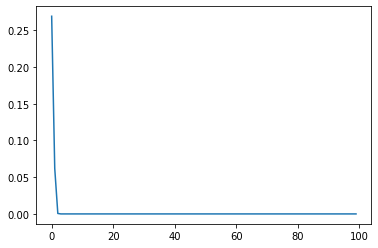

In [14]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

y = []
for i in range(0, 100):
    y.append(sigmoid(-np.exp(i)))
    print(y[-1])

plt.plot(range(len(y)), y)    
plt.show()